# **Cofee Sales**

**created by : Rajat Singh at Unified Mentor**

**Objective:**


1. Loaded and cleaned the coffee sales data.


`
2. Conducted exploratory data analysis (EDA) to visualize sales trends.
`

`
3. Prepared the data for machine learning by handling categorical variables and splitting the dataset.
`

`
4. Trained a model to predict sales.
`

`
5. Evaluated the model's performance.
`

`
6.Created app for prediction and dashboard.
`

In [101]:
# !pip install  -r requirements.txt

In [102]:
#important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pymongo as pm
import os , sys
from logger import logging
from exception import ProjectException
from utils import get_dataframe_from_mongoDb
from config import mongo_client #importing client instance from config file
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler , LabelEncoder , OneHotEncoder 
from sklearn.model_selection import train_test_split , GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor , AdaBoostClassifier , BaggingRegressor 
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import SVR
warnings.filterwarnings("ignore")
import plotly.express as px

# **Data Ingestion**

In [103]:
file_path = os.path.join(os.getcwd() , "dataset/Cofee Sales dataset.csv")
df=pd.read_csv(file_path)

In [104]:
df.columns

Index(['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name'], dtype='object')

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1133 non-null   object 
 1   datetime     1133 non-null   object 
 2   cash_type    1133 non-null   object 
 3   card         1044 non-null   object 
 4   money        1133 non-null   float64
 5   coffee_name  1133 non-null   object 
dtypes: float64(1), object(5)
memory usage: 53.2+ KB


In [106]:
df.isnull().sum() #there are more than 89 NaN values inside Card column 

date            0
datetime        0
cash_type       0
card           89
money           0
coffee_name     0
dtype: int64

In [107]:
#Replacing categorical column with Most Occurring Values
df["card"] = df["card"].fillna(df["card"].mode()[0])
 

In [108]:
df["card"].mode() #checking most occuring value inside card column

0    ANON-0000-0000-0012
Name: card, dtype: object

In [109]:
df.isnull().sum()


date           0
datetime       0
cash_type      0
card           0
money          0
coffee_name    0
dtype: int64

In [110]:
df.describe()

,money
count,1133.000000
mean,33.105808
std,5.035366
min,18.120000
25%,28.900000
50%,32.820000
75%,37.720000
max,40.000000


In [111]:
df.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [112]:
#Lets convert date into pd.datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df["date"] = pd.to_datetime(df["date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1133 non-null   datetime64[ns]
 1   datetime     1133 non-null   datetime64[ns]
 2   cash_type    1133 non-null   object        
 3   card         1133 non-null   object        
 4   money        1133 non-null   float64       
 5   coffee_name  1133 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 53.2+ KB


In [113]:
#lets add some Extra columns month and year using datetime for more visualizations
df["month"]=df["date"].dt.month
df["year"]=df["date"].dt.year
df["hour"]= df["datetime"].dt.hour
df["day"]=df["date"].dt.day 
df["week_day_name"] = df["datetime"].dt.day_name() #week day with names
df["week_day_num"] = df["datetime"].dt.weekday+1 #week day in numericals values


In [114]:
df.head()

,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


In [115]:
#lets check how many numnericals and categorical features are there
print(df.info() , "\n")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1133 non-null   datetime64[ns]
 1   datetime       1133 non-null   datetime64[ns]
 2   cash_type      1133 non-null   object        
 3   card           1133 non-null   object        
 4   money          1133 non-null   float64       
 5   coffee_name    1133 non-null   object        
 6   month          1133 non-null   int32         
 7   year           1133 non-null   int32         
 8   hour           1133 non-null   int32         
 9   day            1133 non-null   int32         
 10  week_day_name  1133 non-null   object        
 11  week_day_num   1133 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(5), object(4)
memory usage: 84.2+ KB
None 



,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


 `
 There are 3 numericals and 3 categorical features
 `
 
`
 Categoricals column : cash , card , cofee_name
`

`
 Numericals column : month , year , money
 `

`
 datetime column : date  and datetime
 `

# **separating categorical and numericals feature**

In [116]:
for column in df.columns:
    print("----------------------------------------")
    print(f"{column} has  {df[column].duplicated().sum()} Duplicates values")
 

----------------------------------------
date has  983 Duplicates values
----------------------------------------
datetime has  0 Duplicates values
----------------------------------------
cash_type has  1131 Duplicates values
----------------------------------------
card has  687 Duplicates values
----------------------------------------
money has  1117 Duplicates values
----------------------------------------
coffee_name has  1125 Duplicates values
----------------------------------------
month has  1128 Duplicates values
----------------------------------------
year has  1132 Duplicates values
----------------------------------------
hour has  1117 Duplicates values
----------------------------------------
day has  1102 Duplicates values
----------------------------------------
week_day_name has  1126 Duplicates values
----------------------------------------
week_day_num has  1126 Duplicates values


**Lets not drop duplicated Values , which helps in further Analysis and Visualization**

In [117]:
df_copy = df.copy() #making copy of dataframe

In [118]:
filter_df=df_copy.drop(["date" , "datetime"]  , axis=1 )   #droping unecessary column 


In [119]:
numericals_columns=[]
for num_column in filter_df.columns:
    if filter_df[num_column].dtype!="O":
        numericals_columns.append(num_column)

categorical_columns=[]    
for cate_column in filter_df.columns:
    if filter_df[cate_column].dtype=="O":
        categorical_columns.append(cate_column)  

print("Numericals columns are :",numericals_columns)     
print("Categoricals columns are :",categorical_columns)     

Numericals columns are : ['money', 'month', 'year', 'hour', 'day', 'week_day_num']
Categoricals columns are : ['cash_type', 'card', 'coffee_name', 'week_day_name']


# **lets check Uniques values for Each Columns**

In [120]:
for columns in numericals_columns:
    print(f"{columns} has {df_copy[columns].unique()} Uniques Values ") 

money has [38.7  28.9  33.8  40.   24.   35.   30.   25.   32.82 39.   37.72 27.92
 29.   34.   23.02 18.12] Uniques Values 
month has [3 4 5 6 7] Uniques Values 
year has [2024] Uniques Values 
hour has [10 12 13 15 16 18 19 11 14 17  9  7 20  8 22 21] Uniques Values 
day has [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] Uniques Values 
week_day_num has [5 6 7 1 2 3 4] Uniques Values 


In [121]:
for columns in categorical_columns:
    print(f"{columns} has {df_copy[columns].unique()} Uniques Values\n")    

cash_type has ['card' 'cash'] Uniques Values

card has ['ANON-0000-0000-0001' 'ANON-0000-0000-0002' 'ANON-0000-0000-0003'
 'ANON-0000-0000-0004' 'ANON-0000-0000-0005' 'ANON-0000-0000-0006'
 'ANON-0000-0000-0007' 'ANON-0000-0000-0008' 'ANON-0000-0000-0009'
 'ANON-0000-0000-0010' 'ANON-0000-0000-0012' 'ANON-0000-0000-0011'
 'ANON-0000-0000-0013' 'ANON-0000-0000-0014' 'ANON-0000-0000-0015'
 'ANON-0000-0000-0016' 'ANON-0000-0000-0017' 'ANON-0000-0000-0018'
 'ANON-0000-0000-0019' 'ANON-0000-0000-0020' 'ANON-0000-0000-0021'
 'ANON-0000-0000-0022' 'ANON-0000-0000-0023' 'ANON-0000-0000-0024'
 'ANON-0000-0000-0025' 'ANON-0000-0000-0026' 'ANON-0000-0000-0027'
 'ANON-0000-0000-0028' 'ANON-0000-0000-0029' 'ANON-0000-0000-0030'
 'ANON-0000-0000-0031' 'ANON-0000-0000-0032' 'ANON-0000-0000-0033'
 'ANON-0000-0000-0034' 'ANON-0000-0000-0035' 'ANON-0000-0000-0036'
 'ANON-0000-0000-0037' 'ANON-0000-0000-0038' 'ANON-0000-0000-0039'
 'ANON-0000-0000-0040' 'ANON-0000-0000-0041' 'ANON-0000-0000-0042'
 'ANON-

# **EDA and Feature Engineering**

In [172]:
num_corr= df_copy[numericals_columns].corr()  #there is only one label inside year
num_corr


,money,month,year,hour,day,week_day_num
money,1.000000,-0.291433,NaN,0.133818,-0.128860,0.059365
month,-0.291433,1.000000,NaN,0.058285,0.138983,-0.026677
year,NaN,NaN,NaN,NaN,NaN,NaN
hour,0.133818,0.058285,NaN,1.000000,0.005219,0.018143
day,-0.128860,0.138983,NaN,0.005219,1.000000,-0.057174
week_day_num,0.059365,-0.026677,NaN,0.018143,-0.057174,1.000000


In [174]:
num_corr.fillna(0 , inplace=True)
num_corr

,money,month,year,hour,day,week_day_num
money,1.000000,-0.291433,0.0,0.133818,-0.128860,0.059365
month,-0.291433,1.000000,0.0,0.058285,0.138983,-0.026677
year,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
hour,0.133818,0.058285,0.0,1.000000,0.005219,0.018143
day,-0.128860,0.138983,0.0,0.005219,1.000000,-0.057174
week_day_num,0.059365,-0.026677,0.0,0.018143,-0.057174,1.000000


<Axes: >

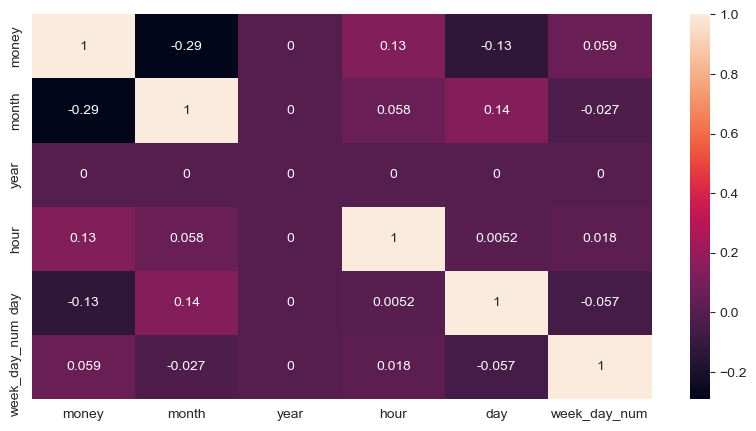

In [177]:
plt.figure(figsize=(10,5))
sns.set_palette("Set2")
sns.set_style("darkgrid")
sns.heatmap(num_corr , annot=True)

**Observation:**

`
There are not much Correlation between each Columns. Some columns has  negative correlation .
`

In [123]:
#lets see top coffee sales 
top_coffee_sales=df_copy["coffee_name"].value_counts()
top_coffee_sales

coffee_name
Americano with Milk    268
Latte                  243
Cappuccino             196
Americano              169
Cortado                 99
Hot Chocolate           74
Espresso                49
Cocoa                   35
Name: count, dtype: int64

Text(0.5, 1.0, 'Coffee Distribution')

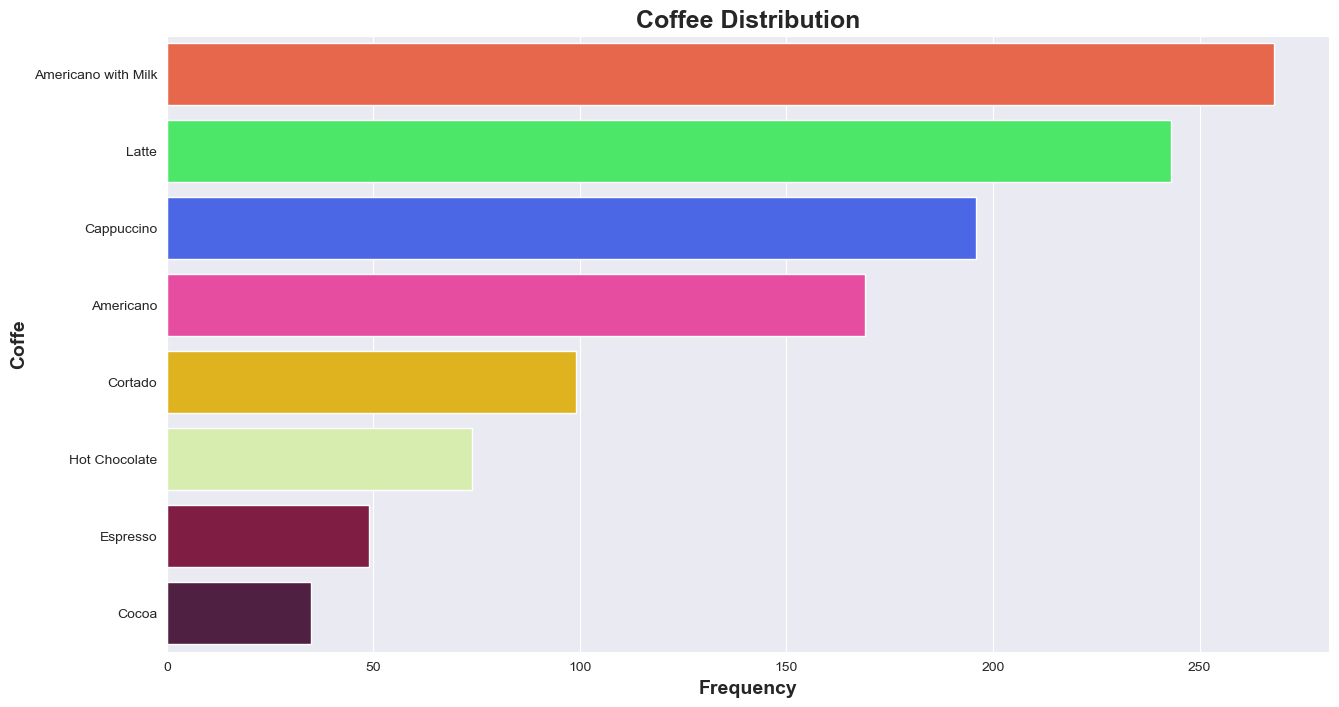

In [124]:
custom_colors = ["#FF5733",  # Vibrant Red
                 "#33FF57",  # Bright Green
                 "#3357FF",  # Vibrant Blue
                 "#FF33A1",  # Hot Pink
                 "#FFC300",  # Yellow
                 "#DAF7A6",  # Light Green
                 "#900C3F",  # Deep Purple
                 "#581845",  # Dark Purple
                 "#FF6F61",  # Coral
                 "#C70039"] 
plt.figure(figsize=(15,8))
sns.set_palette("Spectral")
sns.set_style("darkgrid")
sns.barplot(x = top_coffee_sales.values, y=top_coffee_sales.index , palette=custom_colors)
plt.xlabel("Frequency" , fontsize=14,fontweight="bold")
plt.ylabel("Coffe" , fontsize=14 , fontweight="bold")
plt.title("Coffee Distribution" , fontsize=18 , fontweight="bold")

**Observation :**

`
1.we can see that Americano with milk  , latte and cappuccino are most popular and their sales are higher.**
`

`
2.There are less sales of hot chocolate , Espresso and Cocoa.
`

**Group by Operation  , relation between Coffee and their Prices**

**Most Profitable Product**

In [125]:
df_copy.head()

,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


           coffee_name    money  percentage_of_total_revenue
0            Americano  4644.54                    12.382508
1  Americano with Milk  8601.94                    22.933076
2           Cappuccino  7333.14                    19.550410
3                Cocoa  1295.94                     3.455022
4              Cortado  2745.08                     7.318480
5             Espresso  1100.62                     2.934292
6        Hot Chocolate  2778.48                     7.407526
7                Latte  9009.14                    24.018686


Text(0.5, 1.0, 'Pie chart ')

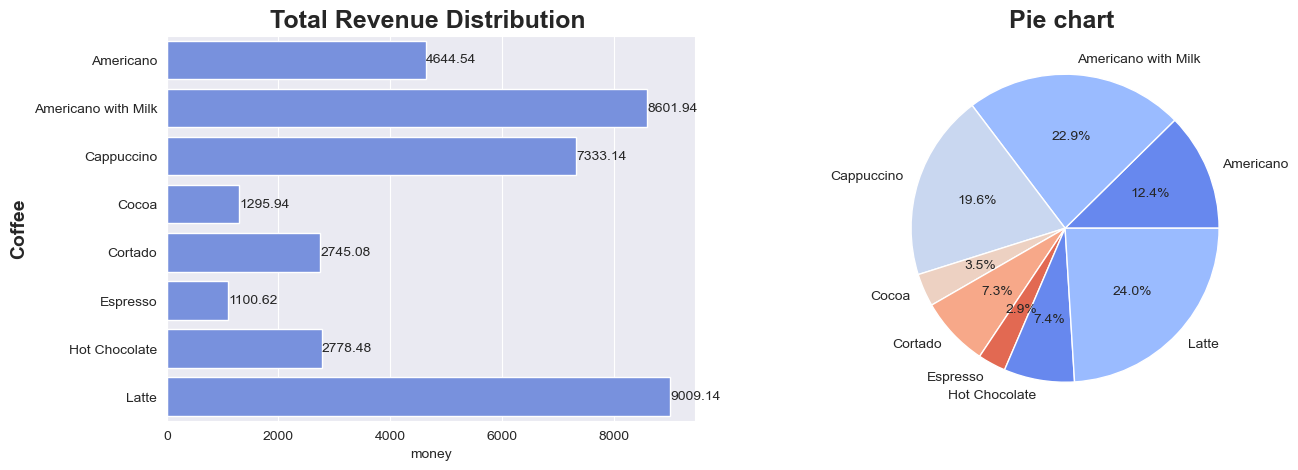

In [126]:
# Group by coffee_name to calculate total revenue for each coffee type
coffee_revenue_df = df.groupby('coffee_name')['money'].sum().reset_index()

# Calculate the total revenue across all coffee types
total_revenue_all = coffee_revenue_df['money'].sum()

# Calculate the percentage of total revenue for each coffee type
coffee_revenue_df['percentage_of_total_revenue'] = (coffee_revenue_df['money'] / total_revenue_all) * 100

# Display the summarized revenue data by coffee type
print(coffee_revenue_df)
sns.set_palette("coolwarm")
sns.set_style("darkgrid")
fig , (ax1 , ax2) = plt.subplots(1,2 , figsize=(15,5))
sns.barplot(data=coffee_revenue_df , y="coffee_name" , x="money", ax=ax1)
ax1.set_ylabel("Coffee" , fontsize=14 , fontweight="bold")
ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.set_title("Total Revenue Distribution " , fontsize=18 , fontweight="bold")
ax2.pie(data=coffee_revenue_df , x="percentage_of_total_revenue"  , labels="coffee_name" , autopct='%1.1f%%')
ax2.set_title("Pie chart " , fontsize=18 , fontweight="bold")

**Observation:**

` 
1.we can see that that most profitable products are Americano with milk , latte , Cuppuccino and Americano .There sales are much higher than others products
`

In [127]:
# Display available palettes
palatte_list=sns.palettes.SEABORN_PALETTES.keys()
print(palatte_list)

dict_keys(['deep', 'deep6', 'muted', 'muted6', 'pastel', 'pastel6', 'bright', 'bright6', 'dark', 'dark6', 'colorblind', 'colorblind6'])


In [128]:
df_copy.loc[: ,["card" , "cash_type" , "coffee_name"]].describe().T

,count,unique,top,freq
card,1133,446,ANON-0000-0000-0012,177
cash_type,1133,2,card,1044
coffee_name,1133,8,Americano with Milk,268


In [129]:
print(df_copy[["card" , "cash_type" , "coffee_name"]].isnull().sum())



card           0
cash_type      0
coffee_name    0
dtype: int64


In [130]:
df_copy["coffee_name"].duplicated().sum()

1125

`
● There are more than 4000 transactions in the data.
`




In [131]:
# Create a histogram
fig = px.histogram(df_copy, 
                   x='cash_type', 
                   color='cash_type', 
                   title='Cash Type Distribution',
                   labels={'cash_type': 'Cash Type'},
                   text_auto=True,  # This will show the count on top of the bars
                   color_discrete_sequence=px.colors.qualitative.Set1  # Custom color palette
                  )

# Update layout for better aesthetics
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))  # Add border to bars
fig.update_layout(xaxis_title='Cash Type', 
                  yaxis_title='Frequency',
                  title_font=dict(size=18, family='Arial Black'),
                  xaxis=dict(title_font=dict(size=14)),
                  yaxis=dict(title_font=dict(size=14)),
                  legend_title_text='Cash Type',
                  legend=dict(font=dict(size=12)))

# Show the plot
fig.show()

In [132]:

df_copy["cash_type"].value_counts()  / df_copy.shape[0]*100 #distribution based on percentage

cash_type
card    92.144748
cash     7.855252
Name: count, dtype: float64

**Observation:**

`
1.There are more than 90 percerntage card transaction.
`

`
2.0nly 7 Percentage cash payments.
`


**Payment percentage  Based on Cofee name**

In [133]:
df_copy.head()

,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


`
Time Series Analysis
`


In [134]:
print(f'Time Range of this dataset is from  {(df_copy["date"].min())} to  {(df_copy["date"].max())}')


Time Range of this dataset is from  2024-03-01 00:00:00 to  2024-07-31 00:00:00


# **Monthly Sale Analysis**

In [135]:
monthly_revenue = df.groupby(['coffee_name', 'month'])['money'].sum().reset_index()
monthly_revenue

,coffee_name,month,money
0,Americano,3,1044.80
1,Americano,4,1001.94
2,Americano,5,1348.80
3,Americano,6,390.88
4,Americano,7,858.12
5,Americano with Milk,3,1154.00
6,Americano with Milk,4,1407.74
7,Americano with Milk,5,1908.28
8,Americano with Milk,6,2268.12
9,Americano with Milk,7,1863.80


In [136]:
pivot_table = monthly_revenue.pivot(index='month', columns='coffee_name', values='money')
pivot_table.columns

Index(['Americano', 'Americano with Milk', 'Cappuccino', 'Cocoa', 'Cortado',
       'Espresso', 'Hot Chocolate', 'Latte'],
      dtype='object', name='coffee_name')

In [137]:

pivot_table

coffee_name,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
month,,,,,,,,
3,1044.80,1154.00,780.50,232.20,869.20,241.00,854.00,1874.50
4,1001.94,1407.74,1659.44,232.82,548.48,171.00,506.02,1193.12
5,1348.80,1908.28,2078.44,340.76,474.64,185.14,529.36,2198.00
6,390.88,2268.12,1735.12,189.88,530.48,230.20,528.08,1886.00
7,858.12,1863.80,1079.64,300.28,322.28,273.28,361.02,1857.52


<Figure size 1000x600 with 0 Axes>

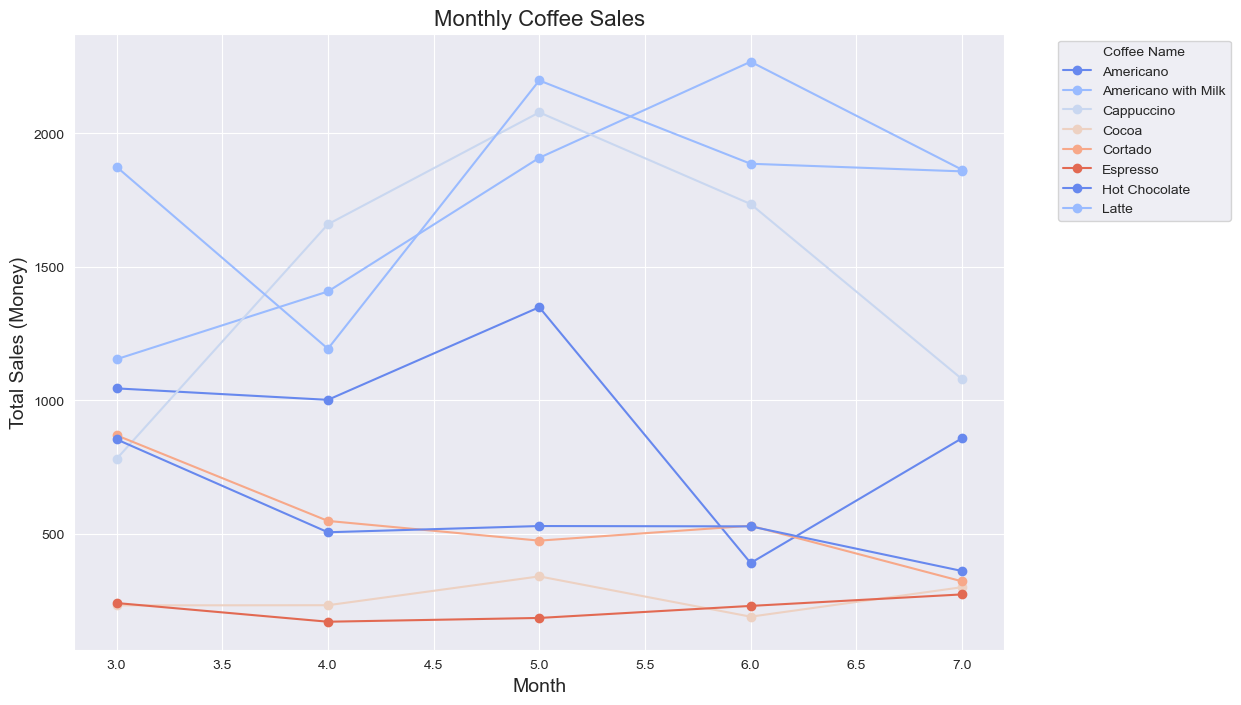

In [138]:
# Plot the monthly sales using a line plot for each coffee type
plt.figure(figsize=(10, 6))
pivot_table.plot(kind='line', marker='o', figsize=(12, 8))

plt.title('Monthly Coffee Sales', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales (Money)', fontsize=14)
plt.legend(title='Coffee Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [139]:
monthly_sales =df_copy.groupby(['coffee_name','month']).count()['date'].reset_index().rename(columns={'date':'count'}).pivot(index='month',columns='coffee_name',values='count').reset_index()
monthly_sales

coffee_name,month,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
0,3,36,34,20,6,30,10,22,48
1,4,35,42,43,6,19,7,13,31
2,5,48,58,55,9,17,8,14,58
3,6,14,69,46,5,19,10,14,50
4,7,36,65,32,9,14,14,11,56


In [140]:
monthly_sales=df_copy.groupby(['coffee_name','month']).count()['date'].reset_index().rename(columns={'date':'count'})

In [141]:
monthly_sales = monthly_sales.pivot(index='month',columns='coffee_name',values='count').reset_index()

In [142]:
monthly_sales

coffee_name,month,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
0,3,36,34,20,6,30,10,22,48
1,4,35,42,43,6,19,7,13,31
2,5,48,58,55,9,17,8,14,58
3,6,14,69,46,5,19,10,14,50
4,7,36,65,32,9,14,14,11,56


In [143]:
monthly_sales.describe().T.loc[:,['min','max']]

,min,max
coffee_name,,
month,3.0,7.0
Americano,14.0,48.0
Americano with Milk,34.0,69.0
Cappuccino,20.0,55.0
Cocoa,5.0,9.0
Cortado,14.0,30.0
Espresso,7.0,14.0
Hot Chocolate,11.0,22.0
Latte,31.0,58.0


In [144]:
monthly_sales

coffee_name,month,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
0,3,36,34,20,6,30,10,22,48
1,4,35,42,43,6,19,7,13,31
2,5,48,58,55,9,17,8,14,58
3,6,14,69,46,5,19,10,14,50
4,7,36,65,32,9,14,14,11,56


([<matplotlib.axis.XTick at 0x2943574f0b0>,
 [Text(0, 0, '3'),
  Text(1, 0, '4'),
  Text(2, 0, '5'),
  Text(3, 0, '6'),
  Text(4, 0, '7')])

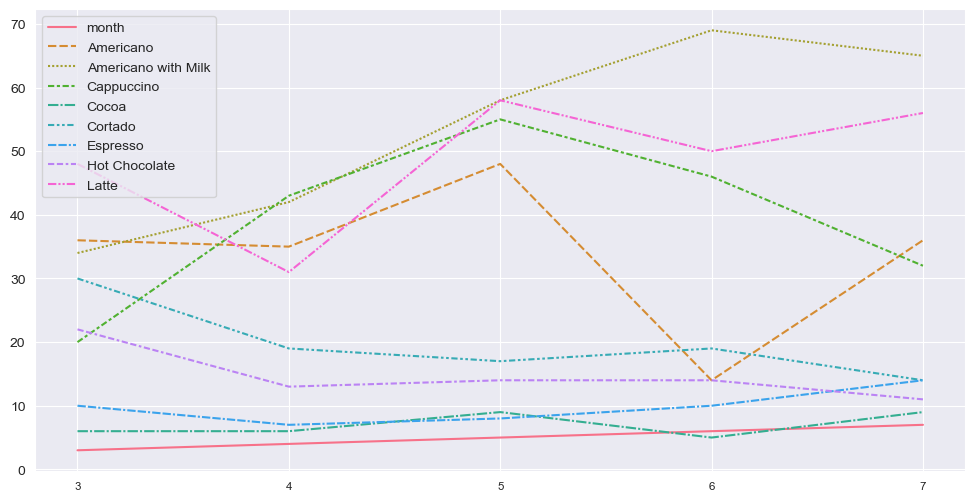

In [145]:
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales)
plt.legend(loc='upper left')
plt.xticks(range(len(monthly_sales['month'])),monthly_sales['month'],size='small')


# **Observations:**

`
1.As illustrated in the line chart above, Americano with Milk, Latte, and Cappuccino are the top-selling coffee types, whereas Cocoa and Espresso exhibit the lowest sales figures. 
`

`
2.Furthermore, Americano with Milk and Latte demonstrate an upward trend in their sales.
`

`
2.Notably, sales tend to rise significantly after May, particularly as we approach the colder months of June and July, which are more favorable for coffee consumption. Additionally, Americano with Milk and latte demonstrate an upward trend in their sales.
`

# **Weekly Analysis**

In [146]:
df_copy.head()

,date,datetime,cash_type,card,money,coffee_name,month,year,hour,day,week_day_name,week_day_num
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,3,2024,10,1,Friday,5
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,3,2024,12,1,Friday,5
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,3,2024,13,1,Friday,5
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,3,2024,13,1,Friday,5


            coffee_name week_day_name  count        day
1             Americano        Monday     37     Monday
5             Americano       Tuesday     26    Tuesday
6             Americano     Wednesday     23  Wednesday
4             Americano      Thursday     24   Thursday
0             Americano        Friday     25     Friday
2             Americano      Saturday     17   Saturday
3             Americano        Sunday     17     Sunday
8   Americano with Milk        Monday     32     Monday
12  Americano with Milk       Tuesday     54    Tuesday
13  Americano with Milk     Wednesday     35  Wednesday
11  Americano with Milk      Thursday     31   Thursday
7   Americano with Milk        Friday     34     Friday
9   Americano with Milk      Saturday     48   Saturday
10  Americano with Milk        Sunday     34     Sunday
15           Cappuccino        Monday     31     Monday
19           Cappuccino       Tuesday     27    Tuesday
20           Cappuccino     Wednesday     29  We

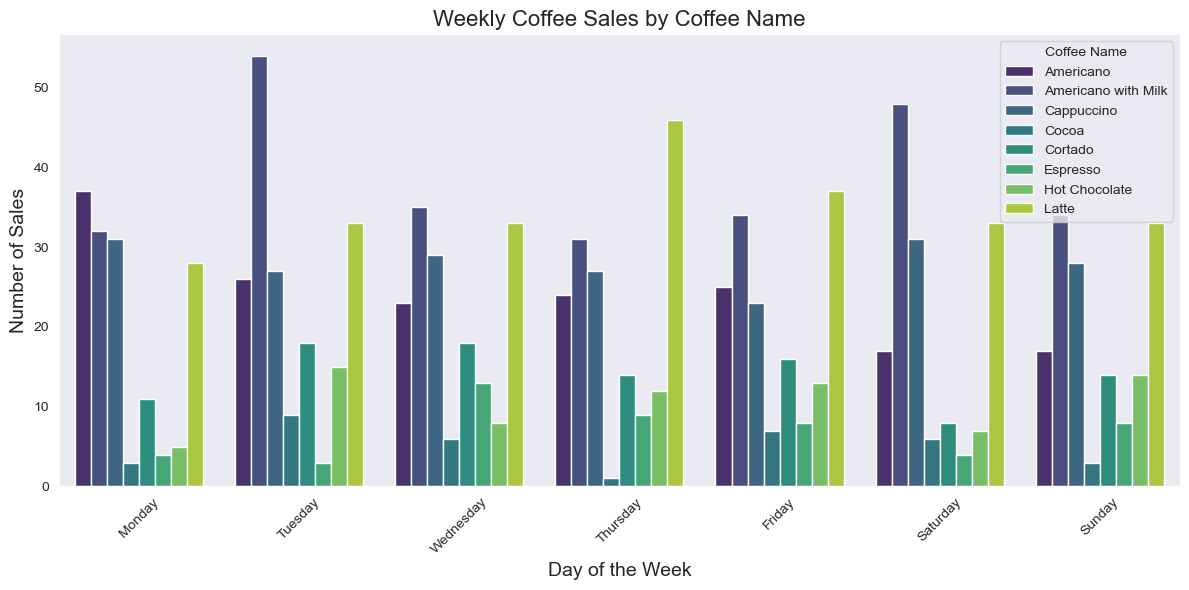

In [147]:
weekly_sales = df_copy.groupby(['coffee_name', 'week_day_name'])['date'].count().reset_index().rename(columns={'date': 'count'})

# Optional: Reorder the days for better visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales['day'] = pd.Categorical(weekly_sales['week_day_name'], categories=day_order, ordered=True)
weekly_sales = weekly_sales.sort_values(['coffee_name', 'day'])

# Display the weekly sales DataFrame
print(weekly_sales)


# Plotting using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=weekly_sales, x='day', y='count', hue='coffee_name', palette='viridis')

plt.title('Weekly Coffee Sales by Coffee Name', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Sales', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Coffee Name')
plt.grid(axis='y')

plt.tight_layout()  # Adjust layout
plt.show()

## Sales Observations

- **Americano** sells best on **Mondays**, while **Latte** is the favorite on **Thursdays**.
- **Americano with Milk** does really well on **Tuesdays**.
- On the other hand, **Cocoa** and **Espresso** aren't selling much at all, so they could really use some advertising to attract more customers.
- **Cortado** is also not doing well in sales.
- Overall, we see that coffee sales are generally higher on the **weekends**.


# **Hourly Sales**

In [148]:
hourly_sales = df_copy.groupby(["hour"]).count()["date"].reset_index().rename(columns={"date":"count"})
hourly_sales

,hour,count
0,7,13
1,8,44
2,9,50
3,10,133
4,11,103
5,12,87
6,13,78
7,14,76
8,15,65
9,16,77


In [149]:
# Assuming 'hourly_sales' is your DataFrame
fig = px.bar(hourly_sales,
             x="hour",
             y="count",
             color="hour",
             title="<b>Coffee Hourly Sales by Date</b>",
             height=500)

# Update layout to make x and y labels bold and ensure all ticks are shown
fig.update_layout(
    xaxis_title="<b>Hour</b>",
    yaxis_title="<b>Count</b>",
    title_x=0.5,  # Center the title (optional)
    xaxis=dict(
        tickmode='linear',  # Ensure all x-axis values are shown
        tick0=0,            # Start at 0
        dtick=1             # Show every tick (step of 1)
    )
)

# Display the chart
fig.show()


# **Observation:**

`1. By observing plot we can find that most of Peak sales  are within 10:00 AM and 7:00 P.M.`


# **Hourly Sales Analysis by Product***

In [150]:
hourly_product_sales = df_copy.groupby(["hour" , "coffee_name"]).count()["date"].reset_index().rename(columns={"date":"count"})
hourly_product_sales=hourly_product_sales.pivot(index='hour',columns='coffee_name',values='count').fillna(0).reset_index()
hourly_product_sales


coffee_name,hour,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
0,7,5.0,4.0,1.0,0.0,1.0,0.0,0.0,2.0
1,8,10.0,7.0,8.0,1.0,6.0,0.0,0.0,12.0
2,9,8.0,16.0,6.0,1.0,5.0,3.0,0.0,11.0
3,10,20.0,31.0,10.0,4.0,8.0,2.0,7.0,51.0
4,11,21.0,25.0,16.0,1.0,13.0,6.0,8.0,13.0
5,12,14.0,26.0,15.0,3.0,7.0,6.0,3.0,13.0
6,13,18.0,18.0,10.0,2.0,12.0,3.0,4.0,11.0
7,14,15.0,18.0,13.0,4.0,6.0,5.0,2.0,13.0
8,15,14.0,15.0,8.0,0.0,3.0,4.0,6.0,15.0
9,16,10.0,18.0,12.0,3.0,12.0,5.0,4.0,13.0


In [151]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# Define a color palette (you can use Plotly's built-in palettes or customize your own)
color_palette = px.colors.qualitative.Pastel  # Using a pastel color palette for better visuals

# Create subplot grid: 2 rows, 4 columns
fig = make_subplots(rows=2, cols=4, subplot_titles=hourly_product_sales.columns[1:])

# Initialize row and column counters
row, col = 1, 1

# Iterate over each coffee product
for i, product in enumerate(hourly_product_sales.columns[1:], start=1):
    # Add a bar trace for each product with color palette
    fig.add_trace(
        go.Bar(x=hourly_product_sales['hour'], 
               y=hourly_product_sales[product], 
               name=product,
               marker_color=color_palette[i % len(color_palette)]),  # Cycle through the palette
        row=row, col=col
    )
    
    # Move to the next column, and next row if needed
    col += 1
    if col > 4:
        col = 1
        row += 1


fig.update_layout(
    height=800,  # Adjust height as needed
    title_text="<b>Hourly Sales by Product</b>",  # Title for the entire figure
    title_font=dict(size=20, family='Arial', color='darkblue'),  # Custom title font
    showlegend=False,  # Disable legend to avoid clutter
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for a clean look
    paper_bgcolor='rgba(255, 255, 255, 1)',  # White background
    font=dict(family="Arial", size=12, color="black")  # Global font style
)

# Customize x and y axes
fig.update_xaxes(title_text="<b>Hour</b>", showgrid=True, gridcolor='lightgray')
fig.update_yaxes(title_text="<b>Sales Count</b>", showgrid=True, gridcolor='lightgray')

# Show the plot
fig.show()


# **Hourly Traffic Analysis for Coffee Products**

The visualizations above display the customer traffic for various coffee products over the course of a day. One clear pattern is that traffic peaks for all products around **10:00 AM**, with the spike being most evident for **Latte**.

During the evening, particularly between **6:00 PM and 8:00 PM**, we observe a preference shift toward beverages like **Cappuccino, Cocoa**, and **Hot Chocolate**, which see higher sales during these hours.

## **Key Insights**

This analysis provides valuable insights into daily and weekly customer behaviors. It highlights the top-selling coffee items and tracks how their popularity fluctuates throughout the day. 

These findings can support decisions in:
- **Inventory management** to avoid stockouts.
- Optimizing **vending machine layouts** for higher engagement.
- Pinpointing the best **restocking times** to meet demand more effectively.




## Summary of Coffee Sales Analysis

This project conducts a detailed analysis of coffee sales distribution across various types of coffee, focusing on daily, weekly, and monthly patterns. Key insights include:

- **Top Sellers**: Americano with Milk, Latte, and Cappuccino lead in sales, while Cocoa and Espresso underperform, suggesting a need for targeted advertising.
  
- **Sales Trends**: Sales for Americano with Milk and Latte show an upward trajectory, particularly as colder months approach after May, when coffee consumption typically increases.

- **Customer Behavior**: Sales data reveals that:
  - Americano is most popular on Mondays, while Latte sees peak sales on Thursdays.
  - Weekends generate higher overall sales, indicating a preference for coffee consumption during these times.

- **Hourly Traffic Patterns**: Customer traffic peaks around **10:00 AM**, especially for Latte. In the evening, between **6:00 PM and 8:00 PM**, beverages like Cappuccino and Hot Chocolate become more popular.

- **Strategic Insights**: Findings from this analysis can enhance inventory management, optimize vending machine layouts, and inform restocking strategies to better meet customer demand.


# **Data Transformation**

In [152]:
print(df_copy.head())

        date                datetime cash_type                 card  money  \
0 2024-03-01 2024-03-01 10:15:50.520      card  ANON-0000-0000-0001   38.7   
1 2024-03-01 2024-03-01 12:19:22.539      card  ANON-0000-0000-0002   38.7   
2 2024-03-01 2024-03-01 12:20:18.089      card  ANON-0000-0000-0002   38.7   
3 2024-03-01 2024-03-01 13:46:33.006      card  ANON-0000-0000-0003   28.9   
4 2024-03-01 2024-03-01 13:48:14.626      card  ANON-0000-0000-0004   38.7   

     coffee_name  month  year  hour  day week_day_name  week_day_num  
0          Latte      3  2024    10    1        Friday             5  
1  Hot Chocolate      3  2024    12    1        Friday             5  
2  Hot Chocolate      3  2024    12    1        Friday             5  
3      Americano      3  2024    13    1        Friday             5  
4          Latte      3  2024    13    1        Friday             5  


In [153]:
train_df = df_copy.drop(["date" , "datetime","week_day_name"] , axis=1)

In [154]:
train_df

,cash_type,card,money,coffee_name,month,year,hour,day,week_day_num
0,card,ANON-0000-0000-0001,38.70,Latte,3,2024,10,1,5
1,card,ANON-0000-0000-0002,38.70,Hot Chocolate,3,2024,12,1,5
2,card,ANON-0000-0000-0002,38.70,Hot Chocolate,3,2024,12,1,5
3,card,ANON-0000-0000-0003,28.90,Americano,3,2024,13,1,5
4,card,ANON-0000-0000-0004,38.70,Latte,3,2024,13,1,5
...,...,...,...,...,...,...,...,...,...
1128,card,ANON-0000-0000-0443,23.02,Cortado,7,2024,20,31,3
1129,card,ANON-0000-0000-0040,27.92,Americano with Milk,7,2024,20,31,3
1130,card,ANON-0000-0000-0444,32.82,Latte,7,2024,21,31,3
1131,card,ANON-0000-0000-0445,32.82,Latte,7,2024,21,31,3


`
Using onehot encoder , converting each labels as separate features.
`

In [155]:
one_hot_encoder = OneHotEncoder(sparse_output=False , drop="first")
encoded_column  = one_hot_encoder.fit_transform(train_df[["card" , "coffee_name"]])

In [156]:
encoded_df=pd.DataFrame(encoded_column ,columns=one_hot_encoder.get_feature_names_out())

In [157]:
encoded_df=encoded_df.astype(int)
encoded_df

,card_ANON-0000-0000-0002,card_ANON-0000-0000-0003,card_ANON-0000-0000-0004,card_ANON-0000-0000-0005,card_ANON-0000-0000-0006,card_ANON-0000-0000-0007,card_ANON-0000-0000-0008,card_ANON-0000-0000-0009,card_ANON-0000-0000-0010,card_ANON-0000-0000-0011,...,card_ANON-0000-0000-0444,card_ANON-0000-0000-0445,card_ANON-0000-0000-0446,coffee_name_Americano with Milk,coffee_name_Cappuccino,coffee_name_Cocoa,coffee_name_Cortado,coffee_name_Espresso,coffee_name_Hot Chocolate,coffee_name_Latte
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1130,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1131,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [158]:
encoded_df.index  = train_df.index
train_df=pd.concat([train_df , encoded_df] , axis=1)

In [159]:
train_df = train_df.drop(["card" , "cash_type" , "coffee_name"] , axis=1)
train_df.head()

,money,month,year,hour,day,week_day_num,card_ANON-0000-0000-0002,card_ANON-0000-0000-0003,card_ANON-0000-0000-0004,card_ANON-0000-0000-0005,...,card_ANON-0000-0000-0444,card_ANON-0000-0000-0445,card_ANON-0000-0000-0446,coffee_name_Americano with Milk,coffee_name_Cappuccino,coffee_name_Cocoa,coffee_name_Cortado,coffee_name_Espresso,coffee_name_Hot Chocolate,coffee_name_Latte
0,38.7,3,2024,10,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.7,3,2024,12,1,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38.7,3,2024,12,1,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,28.9,3,2024,13,1,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38.7,3,2024,13,1,5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# **Model Training**

In [160]:
from sklearn.ensemble import AdaBoostRegressor , GradientBoostingRegressor , RandomForestRegressor
from sklearn.linear_model import Lasso , Ridge , ElasticNet
from xgboost import XGBRegressor 

model = {

     "Linear_Regression" : LinearRegression() , 
     "Ridge" : Ridge() , 
     "Random_Forest_Regression" :RandomForestRegressor() , 
     "Gradient_Boosting_Regression" : GradientBoostingRegressor()  , 
     "Lasso"   : Lasso()   , 
     "Elastic_Net"  : ElasticNet() , 
     "XG_Boost" : XGBRegressor() , 
     "SVR" :SVR()
}

In [161]:
def train_evaluate_model(model , x_train , x_test , y_train , y_test):
    result=[]
    y_predictions={}
  

    for name , model  in model.items():
        model.fit(x_train , y_train)
        y_pred = model.predict(x_test)
        y_predictions[name] = y_pred
        
        MAE = mean_absolute_error(y_test , y_pred)
        MSE = mean_squared_error(y_test , y_pred)
        r2Score = r2_score(y_test , y_pred)
        result.append({"Model" : name , "MAE" :MAE , "MSE" :MSE , "r2_score":r2Score})
        
    
    return result , y_predictions

In [162]:
x=train_df.drop("money" , axis=1)
y= train_df["money"]

x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , random_state=42)

In [163]:
results , y_predictions=train_evaluate_model(model=model , x_train=x_train , x_test=x_test , y_train=y_train , y_test=y_test)
results = pd.DataFrame(results)

In [164]:
print(results)

                          Model       MAE        MSE  r2_score
0             Linear_Regression  0.801704   1.295870  0.930391
1                         Ridge  0.840341   1.167187  0.937304
2      Random_Forest_Regression  0.159133   0.182325  0.990206
3  Gradient_Boosting_Regression  0.358492   0.254095  0.986351
4                         Lasso  3.597356  18.513581  0.005527
5                   Elastic_Net  3.448496  17.102279  0.081336
6                      XG_Boost  0.125408   0.089932  0.995169
7                           SVR  3.566421  19.182289 -0.030393



# **Random Forest Model is performing very Well.**

`
Lets plot and Compare each Models Predicted values with Residuals
`

 

In [165]:
def plot_predictions_and_residuals(model_name:str, y_test, y_pred  , path:str):

    """"
    ============================================================

    model_name :str 

    y_test : test(target)
    
    y_pred : predicted_values

    plot_name  :str =(eg:- linear_model_plot.png)

    =================================================================
 
    """
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Plot 1: True vs Predicted values
    plt.figure(figsize=(14, 6))
    
    # Subplot for predicted vs true values
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, color='blue', label='Predictions')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted Values ({model_name})')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Residuals vs Predicted values
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, color='green', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted Values ({model_name})')
    plt.legend()
    plt.grid(True)
    # Show the plots
    plt.tight_layout()
    
    #save fig 
    plt.savefig(path) 
    plt.show()   
    

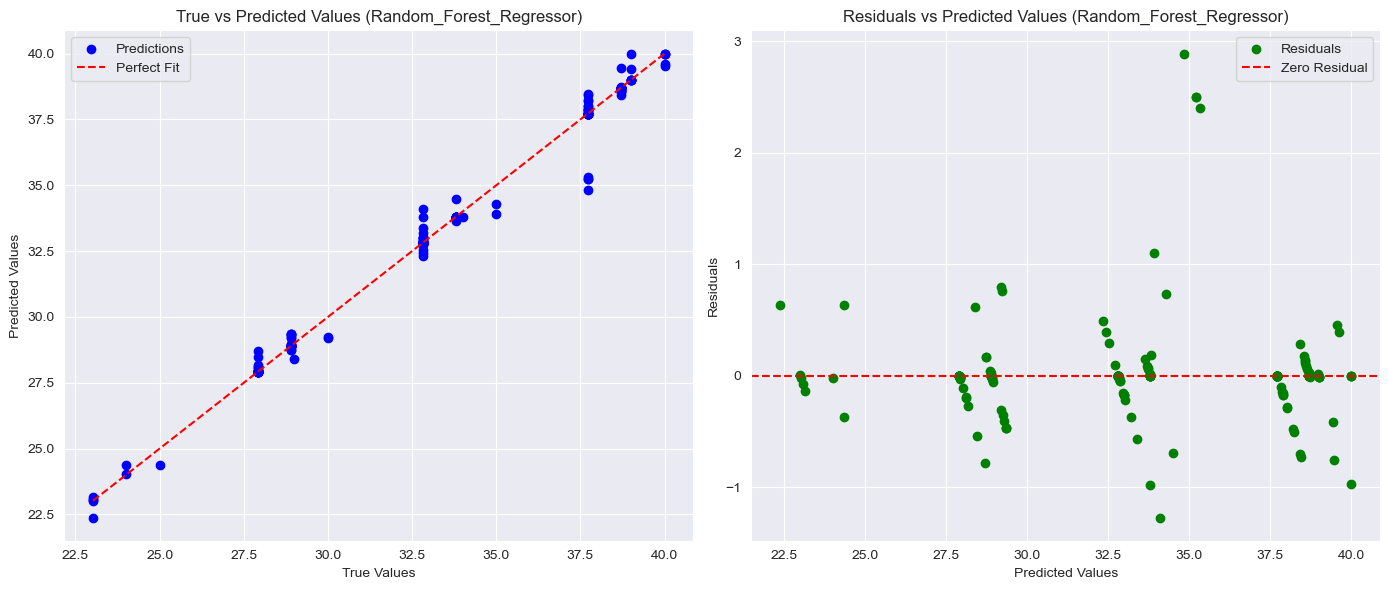

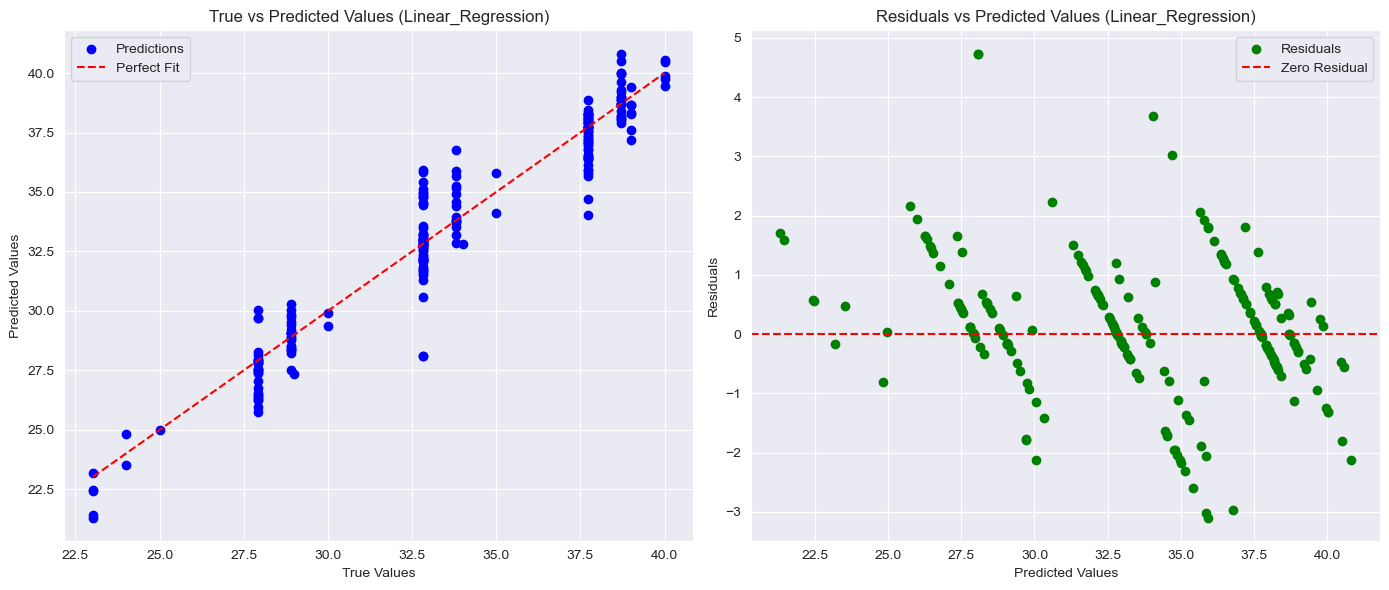

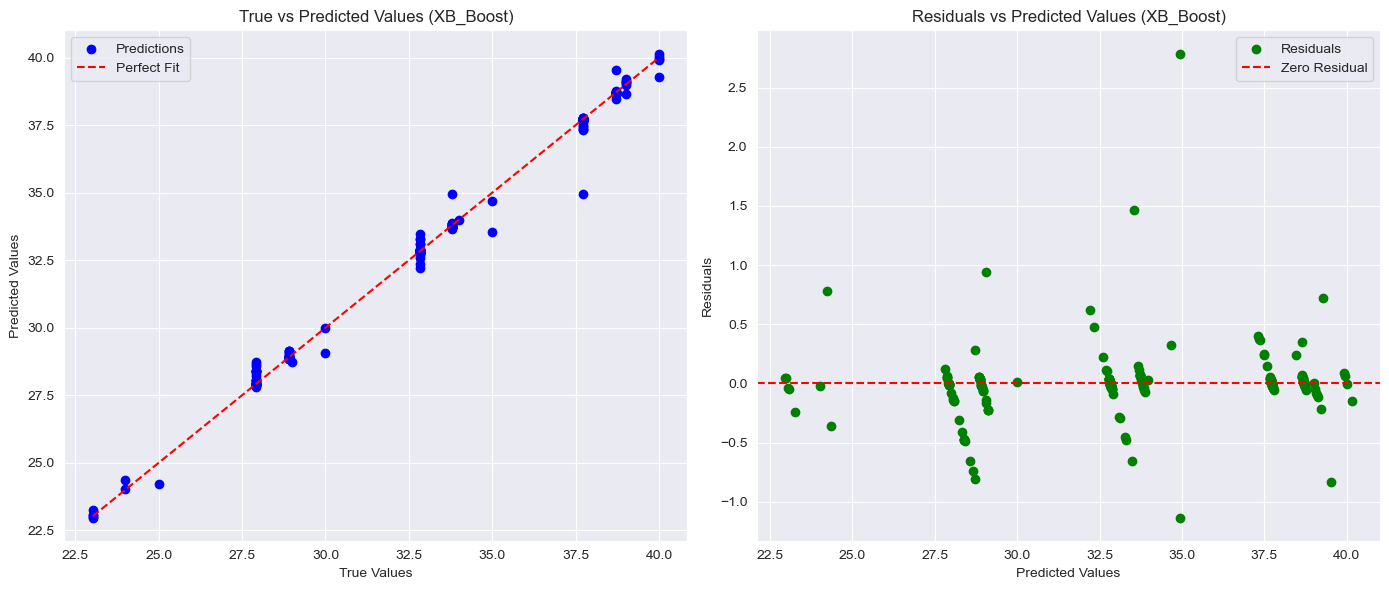

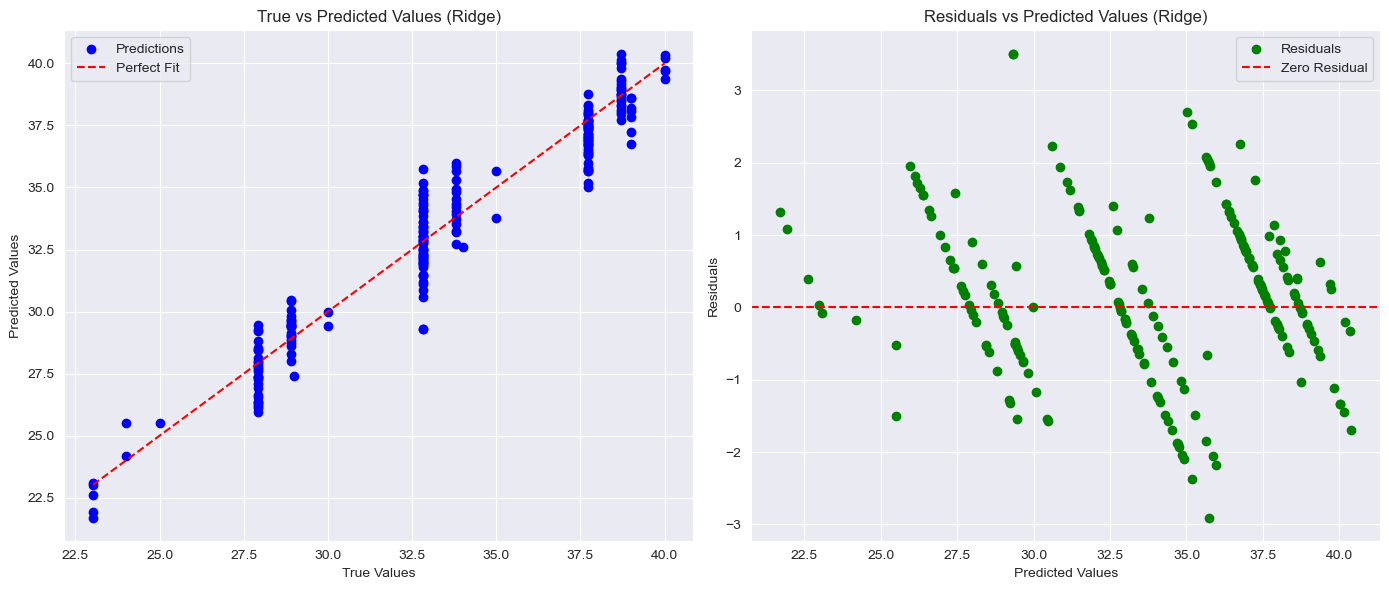

In [166]:
linear_model_name = "Linear_Regression"
Random_model_name = "Random_Forest_Regressor"
xgboost_model= "XB_Boost"
Ridge_model= "Ridge"

Random_Forest_fig=plot_predictions_and_residuals(model_name=Random_model_name,
                                                 y_test=y_test ,
                                                 y_pred=y_predictions["Random_Forest_Regression"] , 
                                                 path="Model_comparision/Random_Forest_Model_fig.png")

Linear_Model_Fig = plot_predictions_and_residuals(model_name=linear_model_name, 
                                                  y_test=y_test , 
                                                  y_pred=y_predictions["Linear_Regression"] ,
                                                  path="Model_comparision/Linear_Model_Fig.png")
XGBoost_Model_Fig = plot_predictions_and_residuals(model_name=xgboost_model, 
                                                  y_test=y_test , 
                                                  y_pred=y_predictions["XG_Boost"] ,
                                                  path="Model_comparision/XGboost_Model_Fig.png")

Ridge_Model_Fig = plot_predictions_and_residuals(model_name=Ridge_model, 
                                                  y_test=y_test , 
                                                  y_pred=y_predictions["Ridge"] ,
                                                  path="Model_comparision/Ridge_Model_Fig.png")




logging.info("Model figure saved inside Model_comparision folder")



**Worst Model:**  `Linear Regression`

**Best Model:** `XGBOOSTRegressor`



# **HyperParameter Tuning**

`
To Find Best Model and its Parameter 
`

In [167]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3]
}


In [168]:
random_search = RandomizedSearchCV(estimator=XGBRegressor(),
                                   param_distributions=param_dist,
                                   n_iter=100,  # Number of parameter settings to try
                                   scoring='neg_mean_squared_error',
                                   cv=3,  # Number of cross-validation folds
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)  # Use all available cores


In [169]:
random_search.fit(x_train , y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'n_estimators': [50, 100, 200, 300],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [170]:
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Predict using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Best Parameters: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Mean Squared Error: 0.08551163088665568
R² Score: 0.9954066683773617
